# E-Commerce Data

The dataset of this project consists of orders made in different countries from December 2010 to December 2011. The company is a UK-based online retailer that mainly sells unique all-occasion gifts. Many of its customers are wholesalers. 

In this project, I analyze the orders and address the following questions:
1. Which products have been returned the most? (Negative order quantities indicate returns)
2. What are the profits earned from UK customers weekly, monthly, and quarterly?
3. Are order sizes from countries outside the United Kingdom significantly larger than orders from inside the United Kingdom?
4. The retailer currently sells over 4000 unique products. To better manage inventory, I will group the products into a small number of categories, ensuring the categories are similar in terms of price and quantity sold.

## Data Dictionary
| Variable    | Explanation                                                                                                                       |
|-------------|-----------------------------------------------------------------------------------------------------------------------------------|
| InvoiceNo   | A 6-digit integral number uniquely assigned to each transaction                                                                   |
| StockCode   | A 5-digit integral number uniquely assigned to each distinct product                                                              |
| Description | Product (item) name                                                                                                               |
| Quantity    | The quantities of each product (item) per transaction                                                                             |
| InvoiceDate | The day and time when each transaction was generated                                                                              |
| UnitPrice   | Product price per unit in sterling (pound)                                                                                        |
| CustomerID  | A 5-digit integral number uniquely assigned to each customer                                                                      |
| Country     | The name of the country where each customer resides                                                                               |

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import ttest_ind
from scipy.stats import mannwhitneyu
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [4]:
# Importing and inspecting the DF
retail = pd.read_csv("online_retail.csv")
retail.head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/10 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/10 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/10 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/10 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/10 8:26,3.39,17850.0,United Kingdom
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,12/1/10 8:26,7.65,17850.0,United Kingdom
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,12/1/10 8:26,4.25,17850.0,United Kingdom
7,536366,22633,HAND WARMER UNION JACK,6,12/1/10 8:28,1.85,17850.0,United Kingdom
8,536366,22632,HAND WARMER RED POLKA DOT,6,12/1/10 8:28,1.85,17850.0,United Kingdom
9,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,12/1/10 8:34,1.69,13047.0,United Kingdom


In [5]:
print(retail.info())
print(retail.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB
None
(541909, 8)


In [6]:
# Inspecting the missing data
descr_na = retail['Description'].isna().sum()
cust_na = retail['CustomerID'].isna().sum()
descr_na_perc = descr_na / retail.shape[0] *100
cust_na_perc = cust_na / retail.shape[0] *100
print(descr_na, descr_na_perc, cust_na, cust_na_perc)

1454 0.2683107311375157 135080 24.926694334288598


The DF information above shows that 'Description' and 'CustomerID' columns have missing values:
1. Approximately 25% of rows are missing 'CustomerID', this is a significant portion of the data. However, I'll keep all rows with the missing 'CustomerID' since none of the analysis tasks are customer-related - they focus on products, orders, and countries.
2. Less than 1% of rows have missing 'Description' - it's safe to drop these rows rather than fill them, as they wouldn't affect the overall analysis.

In [7]:
# Dropping rows with missing 'Description' 
retail_df = retail.dropna(subset = ['Description'])
# Checking for remaining NaN values
print(retail_df['Description'].isna().sum())

0


In [8]:
# Converting 'InvoiceDate' to datetime format
retail_df['InvoiceDate'] = pd.to_datetime(retail_df['InvoiceDate'])
retail_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 540455 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    540455 non-null  object        
 1   StockCode    540455 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     540455 non-null  int64         
 4   InvoiceDate  540455 non-null  datetime64[ns]
 5   UnitPrice    540455 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      540455 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 37.1+ MB


## 1. Returns
The first question I need to investigate is: **Which products have been returned the most?** \
*Note:* negative order quantities indicate returns. 

To answer that question, first, I need to insure that all the data is consistent and clean. To do so I will:
1. Detect whether a product has multiple descriptions for the same 'StockCode'. I will keep only valid product descriptions.
2. Detect whether there are non-sellable StockCode values in the dataset. I will keep only valid product codes.

In [9]:
# Checking for multiple descriptions per 'StockCode'
desc_counts = retail_df.groupby('StockCode')['Description'].nunique().sort_values(ascending=False).reset_index().rename(columns={'Description': 'UniqueDescriptions'})
print(desc_counts)
multi_desc = desc_counts[desc_counts['UniqueDescriptions']>1]
print(multi_desc)

     StockCode  UniqueDescriptions
0        20713                   8
1        23084                   7
2        21830                   6
3        85175                   6
4       72807A                   5
...        ...                 ...
3953     22512                   1
3954     22513                   1
3955     22514                   1
3956     22515                   1
3957         m                   1

[3958 rows x 2 columns]
    StockCode  UniqueDescriptions
0       20713                   8
1       23084                   7
2       21830                   6
3       85175                   6
4      72807A                   5
..        ...                 ...
645     20681                   2
646     23188                   2
647     23135                   2
648     20694                   2
649     22946                   2

[650 rows x 2 columns]


In [10]:
# Getting a quick overview of the duplicates' descriptions
multi_desc_df = retail_df[retail_df['StockCode'].isin(multi_desc['StockCode'])]
print(multi_desc_df
    .groupby(['StockCode', 'Description']).size()
    .reset_index(name='Count')
    .sort_values(['StockCode', 'Count'], ascending=[True, False])
    .reset_index()
    .head(10))

   index StockCode                          Description  Count
0      0     10080             GROOVY CACTUS INFLATABLE     22
1      1     10080                                check      1
2      2     10133         COLOURING PENCILS BROWN TUBE    199
3      3     10133                              damaged      1
4      4    15058A         BLUE POLKADOT GARDEN PARASOL     93
5      5    15058A                            wet/rusty      1
6      6    15058C      ICE CREAM DESIGN GARDEN PARASOL     72
7      7    15058C                            wet/rusty      1
8      8     16008  SMALL FOLDING SCISSOR(POINTED EDGE)     70
9      9     16008                                check      1


The dataset contains many `StockCode`s with multiple descriptions. I will standardize all these rows to the most frequent description to maintain consistency in product-level analysis.

In [11]:
# Getting mode description per 'StockCode'
frequent_desc = retail_df[retail_df['Description'].notna()] \
    .groupby('StockCode')['Description'] \
    .agg(lambda x: x.mode().iloc[0]) \
    .reset_index()
print(frequent_desc)

# Creating a backup of the original descriptions
retail_df['RawDescription'] = retail_df['Description']

# Replacing the old inconsistent 'Description' column with the cleaned description
retail_df = retail_df.drop(columns=['Description'])
retail_df = retail_df.merge(frequent_desc, on='StockCode', how='left')

         StockCode                         Description
0            10002         INFLATABLE POLITICAL GLOBE 
1            10080            GROOVY CACTUS INFLATABLE
2            10120                        DOGGY RUBBER
3           10123C               HEARTS WRAPPING TAPE 
4           10124A         SPOTS ON RED BOOKCOVER TAPE
...            ...                                 ...
3953  gift_0001_20  Dotcomgiftshop Gift Voucher £20.00
3954  gift_0001_30  Dotcomgiftshop Gift Voucher £30.00
3955  gift_0001_40  Dotcomgiftshop Gift Voucher £40.00
3956  gift_0001_50  Dotcomgiftshop Gift Voucher £50.00
3957             m                              Manual

[3958 rows x 2 columns]


In [12]:
# Checking that no more than one description for each 'StockCode' exists
desc_counts2 = retail_df.groupby('StockCode')['Description'].nunique().sort_values(ascending=False).reset_index().rename(columns={'Description': 'UniqueDescriptions'})
multi_desc2 = desc_counts2[desc_counts2['UniqueDescriptions']>1]
print(multi_desc2)

Empty DataFrame
Columns: [StockCode, UniqueDescriptions]
Index: []


In [13]:
# Identifying non-sellable 'StockCode' values

# Detecting non-numeric invalid 'StockCode's
non_numeric_codes = retail_df[retail_df['StockCode'].str.isalpha()]
non_numeric_codes['StockCode'].value_counts()

StockCode
POST         1252
DOT           709
M             571
D              77
S              63
AMAZONFEE      34
CRUK           16
DCGSSGIRL      13
DCGSSBOY       11
PADS            4
B               3
m               1
Name: count, dtype: int64

The `StockCode`s above are invalid and non-sellable. I will remove rows with those codes to ensure the analysis focuses exclusively on actual product sales.

In [14]:
# Creating a list of invalid 'StockCode' values
non_sellable_codes = list(non_numeric_codes['StockCode'].unique())

# Removing rows with invalid 'StockCode'
retail_df_clean = retail_df[~retail_df['StockCode'].isin(non_sellable_codes)]

# Overview of the cleaned dataset
retail_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 537701 entries, 0 to 540454
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   InvoiceNo       537701 non-null  object        
 1   StockCode       537701 non-null  object        
 2   Quantity        537701 non-null  int64         
 3   InvoiceDate     537701 non-null  datetime64[ns]
 4   UnitPrice       537701 non-null  float64       
 5   CustomerID      405055 non-null  float64       
 6   Country         537701 non-null  object        
 7   RawDescription  537701 non-null  object        
 8   Description     537701 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(5)
memory usage: 41.0+ MB


In [15]:
# Identifying anomalous 'StockCode' lenghts
retail_df_clean['StockCodeLength'] = retail_df_clean['StockCode'].str.len()
retail_df_clean['StockCodeLength'].value_counts()

StockCodeLength
5     485992
6      51093
7        390
2        143
12        69
8         14
Name: count, dtype: int64

Stock codes with 5 or 6 digits are common in retail. Codes with other lenghts are rare, and, moreover, represent less than 1% of the data combined, thus I will exclude them to reduce noise and maintain consistency in product-level analysis.

In [16]:
# Removing rows with invalid 'StockCode'
retail_df_clean = retail_df_clean[retail_df_clean['StockCodeLength'].isin([5,6])]

# Overview of the cleaned dataset
retail_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 537085 entries, 0 to 540454
Data columns (total 10 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   InvoiceNo        537085 non-null  object        
 1   StockCode        537085 non-null  object        
 2   Quantity         537085 non-null  int64         
 3   InvoiceDate      537085 non-null  datetime64[ns]
 4   UnitPrice        537085 non-null  float64       
 5   CustomerID       404613 non-null  float64       
 6   Country          537085 non-null  object        
 7   RawDescription   537085 non-null  object        
 8   Description      537085 non-null  object        
 9   StockCodeLength  537085 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(2), object(5)
memory usage: 45.1+ MB


In [17]:
# Identifying top 20 most returned products
returns = retail_df_clean[retail_df_clean['Quantity']<0]
returns_by_product = returns.groupby(['StockCode','Description'], as_index=False)['Quantity'].sum()
returns_by_product['Quantity'] = returns_by_product['Quantity'].abs()
returns_by_product = returns_by_product.sort_values('Quantity', ascending=False)
print(returns_by_product.head(20))

     StockCode                          Description  Quantity
1574     23843          PAPER CRAFT , LITTLE BIRDIE     80995
1320     23166       MEDIUM CERAMIC TOP STORAGE JAR     74494
1204     23005     TRAVEL CARD WALLET I LOVE LONDON     19201
1771     84347  ROTATING SILVER ANGELS T-LIGHT HLDR      9376
1202     23003     TRAVEL CARD WALLET VINTAGE ROSE       9058
1685    72140F                           throw away      5368
1726    79323W               Unsaleable, destroyed.      4838
52       20713                       JUMBO BAG OWLS      4143
1647    47566B               TEA TIME PARTY BUNTING      4024
1802     84598        BOYS ALPHABET IRON ON PATCHES      3288
150      21108   FAIRY CAKE FLANNEL ASSORTED COLOUR      3150
1408     23270     SET OF 2 CERAMIC PAINTED HEARTS       2886
2000     85175                CACTI T-LIGHT CANDLES      2870
1971    85123A   WHITE HANGING HEART T-LIGHT HOLDER      2834
906      22617           BAKING SET SPACEBOY DESIGN      2629
109     

I analysed the most returned products by examining for negative quantities in the sales data. This analysis showed that a small number of items are responsible for the most returns:
- 'PAPER CRAFT , LITTLE BIRDIE' (StockCode 23843) - 80995 returns
- 'MEDIUM CERAMIC TOP STORAGE JAR' (StockCode 23166) - 74494 returns
- 'TRAVEL CARD WALLET I LOVE LONDON' (StockCode 23005) - 19201 returns

This indicates that a small number of products are causing most of the returns.

Also, some of these items were clearly unsellable, like damaged or thrown-away stock. Others might be getting returned because they break easily or don’t meet customers expectations. Based on this, the company could improve product pages, fix packaging issues, or review whether these items should stay in stock.

In [18]:
# Excluding junk/unsellable products
junk_keywords = ['throw', 'unsale', 'unsold', 'destroyed', 'rusty', 'damaged', 'waste', 'adjustment']
returns_by_product['IsJunk'] = returns_by_product['Description'].str.lower().str.contains('|'.join(junk_keywords))
top_returns_clean = returns_by_product[returns_by_product['IsJunk']==False].head(10)
print(top_returns_clean)

     StockCode                          Description  Quantity  IsJunk
1574     23843          PAPER CRAFT , LITTLE BIRDIE     80995   False
1320     23166       MEDIUM CERAMIC TOP STORAGE JAR     74494   False
1204     23005     TRAVEL CARD WALLET I LOVE LONDON     19201   False
1771     84347  ROTATING SILVER ANGELS T-LIGHT HLDR      9376   False
1202     23003     TRAVEL CARD WALLET VINTAGE ROSE       9058   False
52       20713                       JUMBO BAG OWLS      4143   False
1647    47566B               TEA TIME PARTY BUNTING      4024   False
1802     84598        BOYS ALPHABET IRON ON PATCHES      3288   False
150      21108   FAIRY CAKE FLANNEL ASSORTED COLOUR      3150   False
1408     23270     SET OF 2 CERAMIC PAINTED HEARTS       2886   False


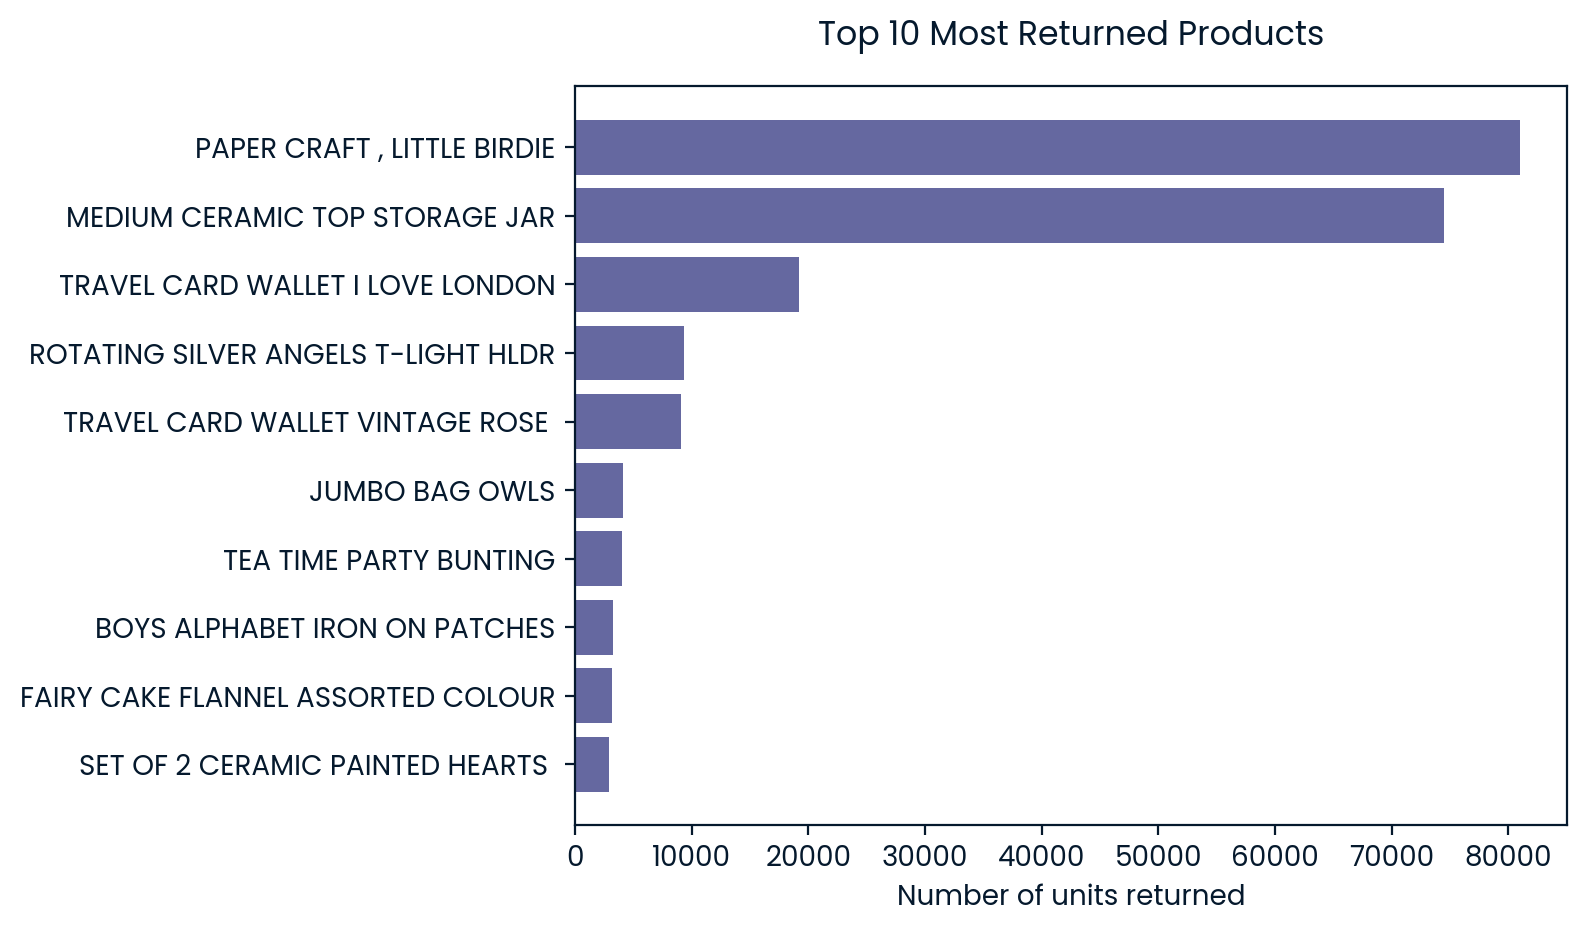

In [19]:
# Visualizing top 10 returned products
plt.barh(data=top_returns_clean, width='Quantity', y='Description')
plt.gca().invert_yaxis()
plt.xlabel('Number of units returned')
plt.title('Top 10 Most Returned Products', pad=15)
plt.show()

By analyzing which products were returned the most, I identified items responsible for the greatest financial loss or customer dissatisfaction. This insight can help the business take corrective action, including quality checks, improved packaging, or enhanced product descriptions. Those actions can ultimately reduce return-related costs and improve customer trust.

I also plan to conduct a deeper analysis by calculating the return rate for each product, as this can uncover hidden issues even when total return counts are low.

In [20]:
# Calculating return rate
# Calculating total units sold per product
sold = retail_df_clean[(retail_df_clean['Quantity']>0) & (retail_df_clean['UnitPrice']>0)]
sold_by_product = sold.groupby(['StockCode','Description'], as_index=False)['Quantity'].sum().sort_values('Quantity', ascending=False)
sold_by_product.rename(columns={'Quantity': 'SoldQty'}, inplace=True)
print(sold_by_product)

     StockCode                        Description  SoldQty
2463     23843        PAPER CRAFT , LITTLE BIRDIE    80995
2018     23166     MEDIUM CERAMIC TOP STORAGE JAR    78033
1107     22197                     POPCORN HOLDER    56921
2907     84077  WORLD WAR 2 GLIDERS ASSTD DESIGNS    55047
3385    85099B            JUMBO BAG RED RETROSPOT    48474
...        ...                                ...      ...
3658    90081B    LILY BROOCH WHITE/SILVER COLOUR        1
3664     90084    PINK CRYSTAL GUITAR PHONE CHARM        1
3669     90092      BLUE CRYSTAL BOOT PHONE CHARM        1
496      21310                   CAPIZ CHANDELIER        1
3104    84743C         ORANGE FELT VASE + FLOWERS        1

[3898 rows x 3 columns]


To prioritize impactful problems and avoid being misled by statistical noise, I will set a minimum sales threshold of approximately 0.01% before flagging items with high return rates.

In [21]:
# Defining total sold quantity
total_sold = sold['Quantity'].sum()
print(total_sold)

# Defining 0.01% threshold
threshold = round(0.0001*total_sold)
print(threshold)

5574065
557


In [22]:
# Updating the df with the threshold
sold_by_product = sold_by_product[sold_by_product['SoldQty']>=threshold]
print(sold_by_product)

     StockCode                         Description  SoldQty
2463     23843         PAPER CRAFT , LITTLE BIRDIE    80995
2018     23166      MEDIUM CERAMIC TOP STORAGE JAR    78033
1107     22197                      POPCORN HOLDER    56921
2907     84077   WORLD WAR 2 GLIDERS ASSTD DESIGNS    55047
3385    85099B             JUMBO BAG RED RETROSPOT    48474
...        ...                                 ...      ...
2004     23152  IVORY SWEETHEART WIRE LETTER RACK       558
2248     23418            LAVENDER TOILETTE BOTTLE      558
3253     84969  BOX OF 6 ASSORTED COLOUR TEASPOONS      558
2483    35598B           BLACK CHRISTMAS TREE 60CM      558
1886     23026      DRAWER KNOB VINTAGE GLASS STAR      557

[1690 rows x 3 columns]


In [23]:
# Merging returns and sales
returns_with_sales = returns_by_product[returns_by_product['IsJunk']==False].merge(sold_by_product, on=['StockCode','Description'], how='left')

# Calculating return rate
returns_with_sales['ReturnRate'] = returns_with_sales['Quantity'] / returns_with_sales['SoldQty']

# Dropping NaN values of 'ReturnRate' (e.g. products never sold but returned)
returns_with_sales = returns_with_sales.dropna(subset=['ReturnRate'])

# Displaying top 10 return rates
top_return_rates = returns_with_sales.sort_values('ReturnRate', ascending=False).head(10)
print(top_return_rates)

   StockCode                          Description  ...  SoldQty  ReturnRate
2      23005     TRAVEL CARD WALLET I LOVE LONDON  ...   4783.0    4.014426
9      23270     SET OF 2 CERAMIC PAINTED HEARTS   ...   1183.0    2.439560
21    85036C      ROSE 1 WICK MORRIS BOXED CANDLE  ...    758.0    2.317942
15     23113                PANTRY CHOPPING BOARD  ...   1154.0    2.067591
36     23269     SET OF 2 CERAMIC CHRISTMAS TREES  ...    786.0    1.832061
6     47566B               TEA TIME PARTY BUNTING  ...   2382.0    1.689337
29     21620      SET OF 4 ROSE BOTANICAL CANDLES  ...    897.0    1.671126
7      84598        BOYS ALPHABET IRON ON PATCHES  ...   1975.0    1.664810
16     85172        HYACINTH BULB T-LIGHT CANDLES  ...   1346.0    1.560921
49    72807C  SET/3 VANILLA SCENTED CANDLE IN BOX  ...    721.0    1.552011

[10 rows x 6 columns]


Some products showed a return rate above 100%, likely due to missing sales data. I will flag these outliers for potential follow-up and exclude them from the return rate calculations below, as this is outside the scope of this project.

In [24]:
# Displaying top 10 return rates without outliers
returns_with_sales['ReturnRateFlag'] = returns_with_sales['ReturnRate']>1
top_return_rates = returns_with_sales[returns_with_sales['ReturnRate']<=1].sort_values('ReturnRate', ascending=False).head(10)[['StockCode', 'Description', 'Quantity', 'SoldQty', 'ReturnRate']]
top_return_rates.head(10)

,StockCode,Description,Quantity,SoldQty,ReturnRate
0,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,80995.0,1.000000
3,84347,ROTATING SILVER ANGELS T-LIGHT HLDR,9376,9476.0,0.989447
1,23166,MEDIUM CERAMIC TOP STORAGE JAR,74494,78033.0,0.954647
76,23057,BEADED CHANDELIER T-LIGHT HOLDER,713,776.0,0.918814
27,79164,BLACK WINE GLASS,1515,1672.0,0.906100
65,23056,FLOWERS CHANDELIER T-LIGHT HOLDER,789,966.0,0.816770
69,72802B,OCEAN SCENT CANDLE IN JEWELLED BOX,744,1028.0,0.723735
43,21700,BIG DOUGHNUT FRIDGE MAGNETS,1242,1726.0,0.719583
114,22796,PHOTO FRAME 3 CLASSIC HANGING,415,584.0,0.710616
23,21830,ASSORTED CREEPY CRAWLIES,1703,2669.0,0.638067


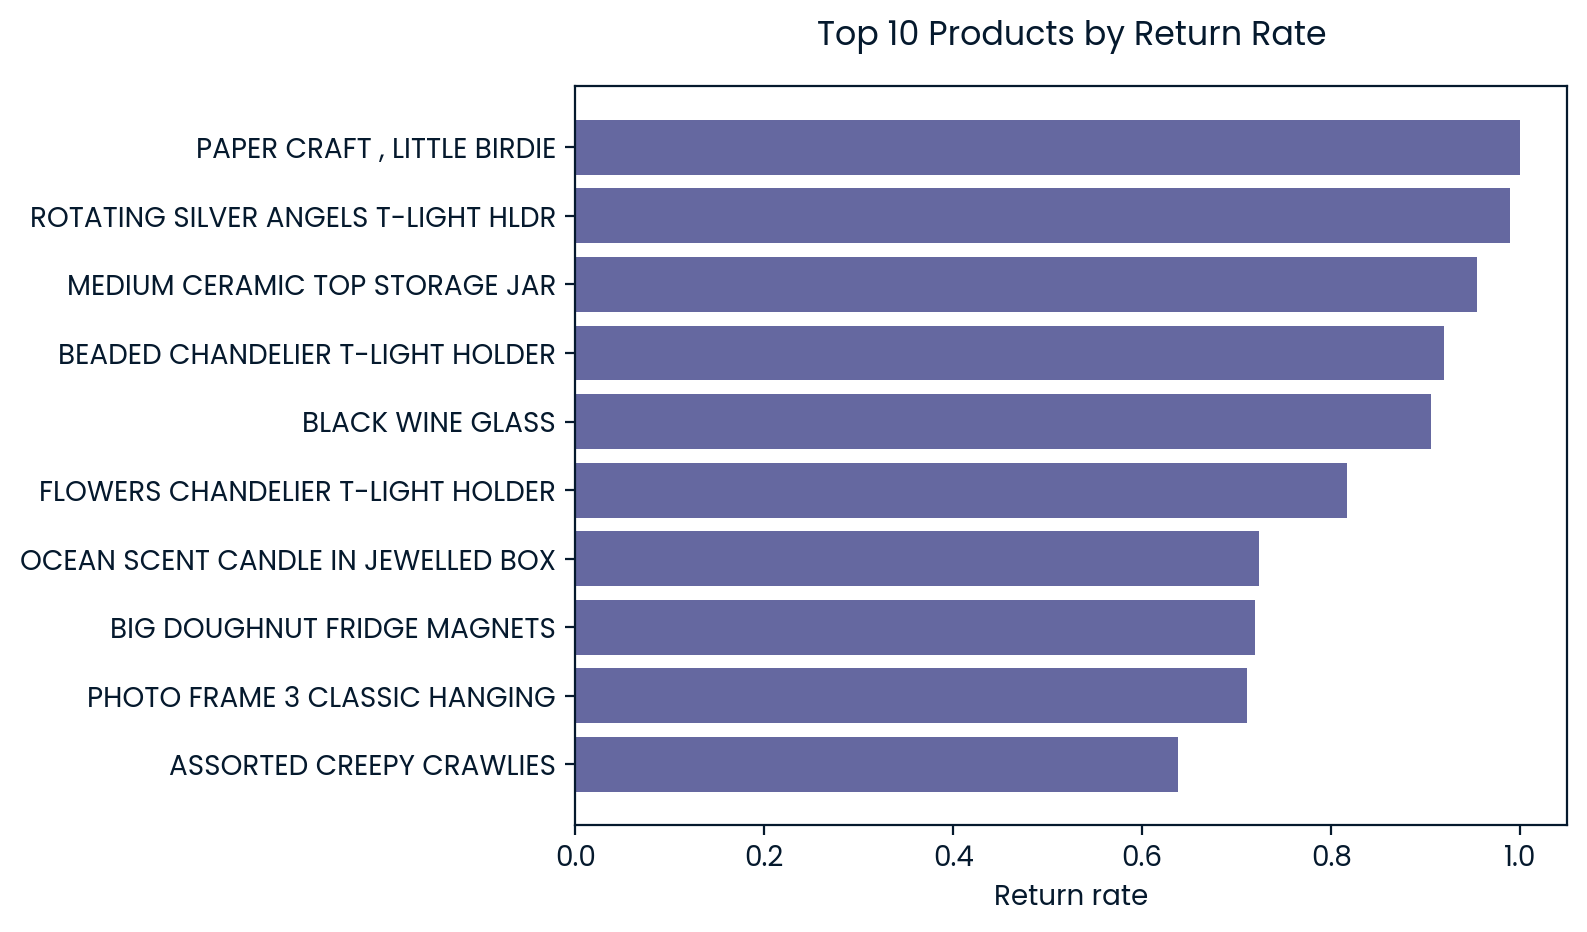

In [25]:
# Visualizing top 10 return rates
plt.barh(data=top_return_rates, width='ReturnRate', y='Description')
plt.gca().invert_yaxis()
plt.xlabel('Return rate')
plt.title('Top 10 Products by Return Rate', pad=15)
plt.show()

These 10 products with the highest return rates indicate major quality or listing issues that affect customer satisfaction and revenue. These items should be prioritized by the business for immediate review to lower returns and losses.

In [26]:
# Finding intersection between top returns and top return rates
problem_codes = set(top_returns_clean['StockCode']) & set(top_return_rates['StockCode'])
problem_products = returns_with_sales[returns_with_sales['StockCode'].isin(problem_codes)][['StockCode', 'Description', 'Quantity', 'SoldQty', 'ReturnRate']]
print(problem_products)

  StockCode                          Description  Quantity  SoldQty  ReturnRate
0     23843          PAPER CRAFT , LITTLE BIRDIE     80995  80995.0    1.000000
1     23166       MEDIUM CERAMIC TOP STORAGE JAR     74494  78033.0    0.954647
3     84347  ROTATING SILVER ANGELS T-LIGHT HLDR      9376   9476.0    0.989447


The products that appear among both the top return rates and top return quantities are shown in the table above. I identify them as critical return risks, as they fail frequently and in high volume. Those products should be prioritized for business review and action.

## 2. UK Profit
The second topic I need to investigate is **the profits earned from UK customers weekly, monthly, and quarterly.**

In [27]:
# Filtering United Kingdom customers' sales
sold_uk = sold[sold['Country']=='United Kingdom']

# Creating a profits column
sold_uk['TotalPrice'] = sold_uk['Quantity'] * sold_uk['UnitPrice']

# Resampling by weeks, months, and quaters
sold_uk = sold_uk.set_index('InvoiceDate')

weekly_uk_sales = sold_uk['TotalPrice'].resample('W').sum().reset_index()
weekly_uk_sales['Type'] = 'Weekly'

monthly_uk_sales = sold_uk['TotalPrice'].resample('M').sum().reset_index()
monthly_uk_sales['Type'] = 'Monthly'

quarterly_uk_sales = sold_uk['TotalPrice'].resample('Q').sum().reset_index()
quarterly_uk_sales['Type'] = 'Quarterly'

combined_uk_sales = pd.concat([weekly_uk_sales, monthly_uk_sales, quarterly_uk_sales])

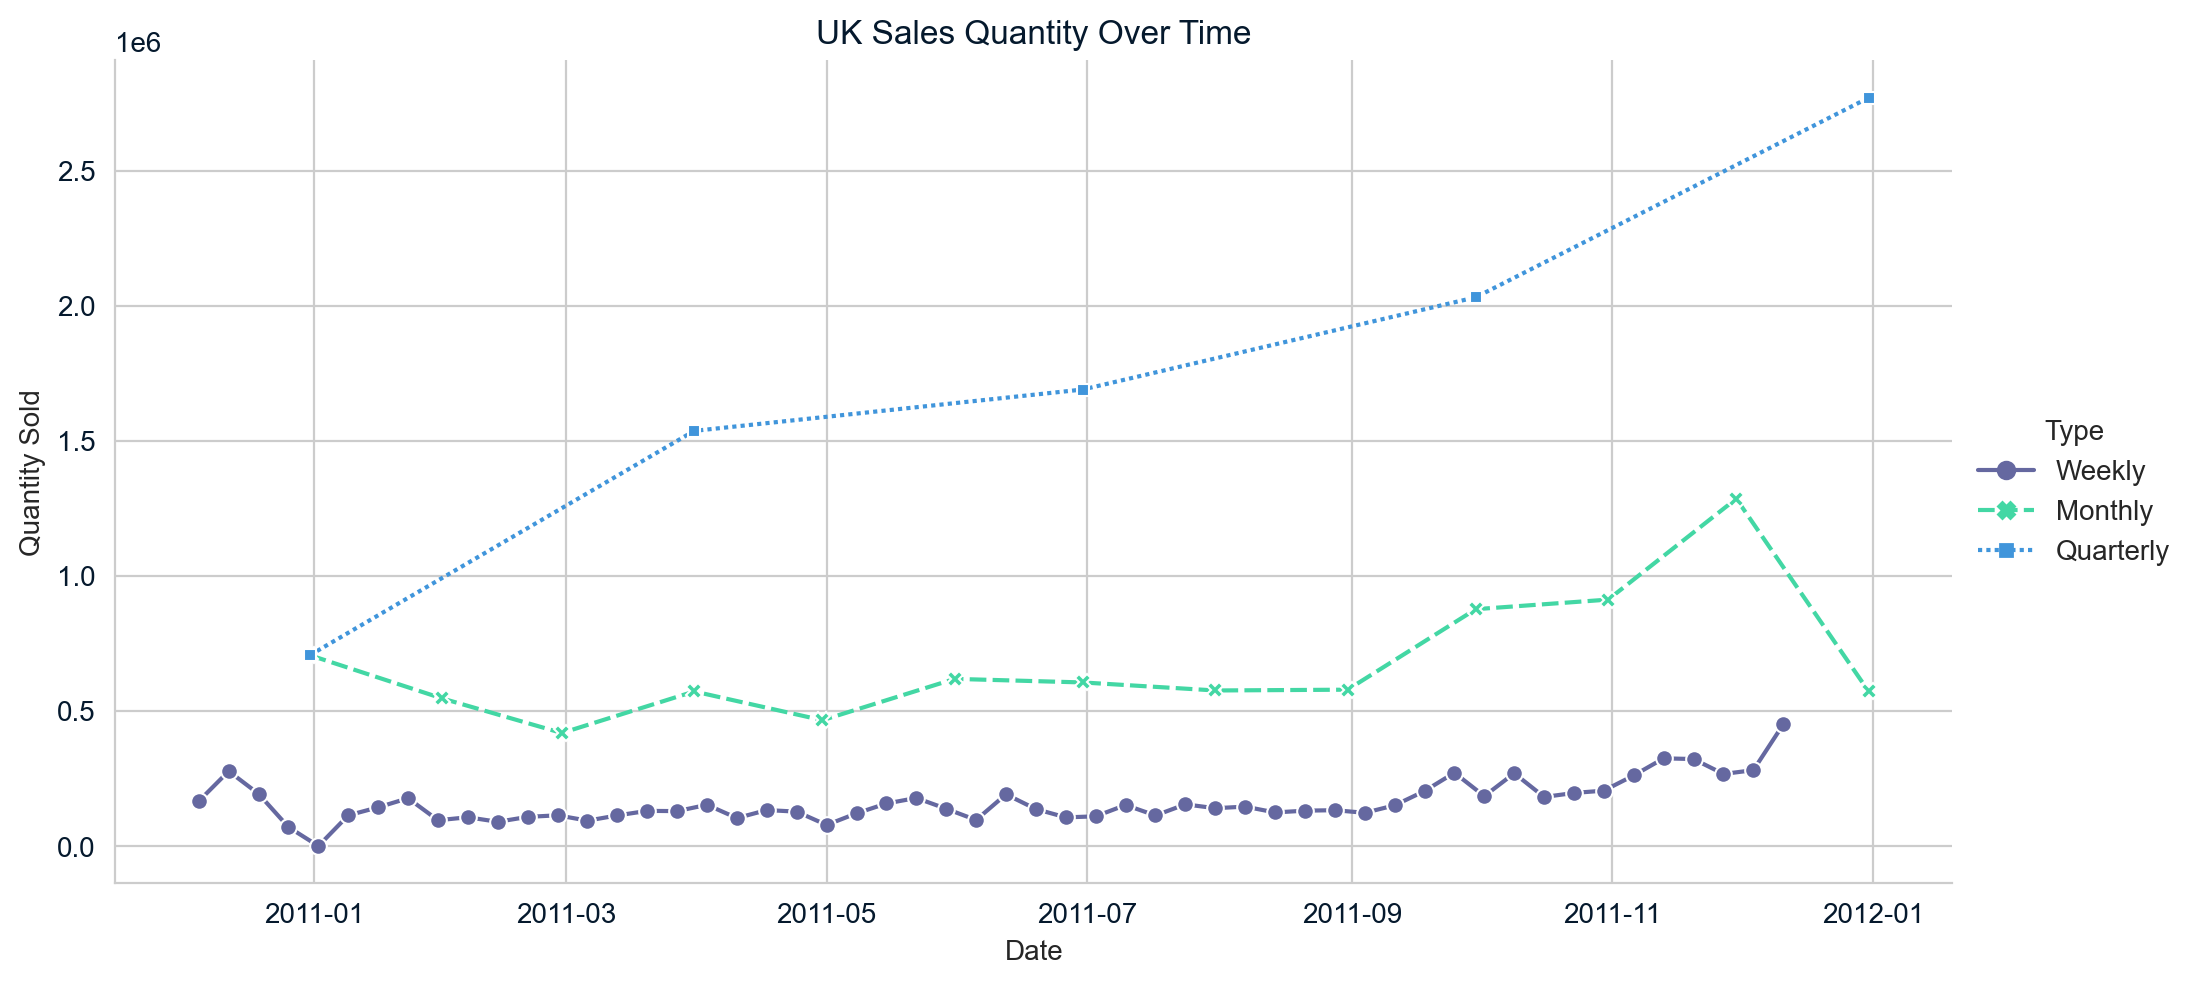

In [28]:
# Visualizing weekly, monthly, and quaterly UK sales
sns.set_style('whitegrid')
sns.relplot(x='InvoiceDate', y='TotalPrice', data=combined_uk_sales, kind='line', style='Type', hue='Type', markers=True, aspect=2)
plt.title("UK Sales Quantity Over Time")
plt.xlabel("Date")
plt.ylabel("Quantity Sold")
plt.show()

The plot shows that **weekly** sales are consistent, with a slight upward shift in the later weeks, indicating stable demand.\
**Monthly** trends highlight stronger performance in recent months, pointing to increased profitability.\
The **quarterly** view confirms an overall growth trend, suggesting that the business is not only maintaining steady sales but also experiencing gradual growth.

## 3. Order sizes comparison by countries
The third question I need to investigate is: **Are order sizes from countries outside the United Kingdom significantly larger than orders from inside the United Kingdom?**

To answer that question, I will perform a t-test as we need to compare sample statistics across groups of a variable (UK and non-UK countries).

Hypotheses:
- Ho: The order sizes from countries outside the UK are the same as for orders from inside the UK.
- Ha: The order sizes from countries outside the UK are larger than orders from inside the UK.

But before doing that I will prepare the dataframe and also visualise the distributions of UK and non-UK orders to check whether performing a t-test is the right choice.

In [29]:
# Adding a new 'TotalPrice' column
sold['TotalPrice'] = sold['Quantity'] * sold['UnitPrice']
sold.head()

,InvoiceNo,StockCode,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,RawDescription,Description,StockCodeLength,TotalPrice
0,536365,85123A,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,WHITE HANGING HEART T-LIGHT HOLDER,WHITE HANGING HEART T-LIGHT HOLDER,6,15.30
1,536365,71053,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,WHITE METAL LANTERN,WHITE METAL LANTERN,5,20.34
2,536365,84406B,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,CREAM CUPID HEARTS COAT HANGER,CREAM CUPID HEARTS COAT HANGER,6,22.00
3,536365,84029G,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,KNITTED UNION FLAG HOT WATER BOTTLE,KNITTED UNION FLAG HOT WATER BOTTLE,6,20.34
4,536365,84029E,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,RED WOOLLY HOTTIE WHITE HEART.,RED WOOLLY HOTTIE WHITE HEART.,6,20.34


In [30]:
# Distinguishing UK from non-UK orders
sold['IsUK'] = sold['Country']=='United Kingdom'
sold.head()

,InvoiceNo,StockCode,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,RawDescription,Description,StockCodeLength,TotalPrice,IsUK
0,536365,85123A,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,WHITE HANGING HEART T-LIGHT HOLDER,WHITE HANGING HEART T-LIGHT HOLDER,6,15.30,True
1,536365,71053,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,WHITE METAL LANTERN,WHITE METAL LANTERN,5,20.34,True
2,536365,84406B,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,CREAM CUPID HEARTS COAT HANGER,CREAM CUPID HEARTS COAT HANGER,6,22.00,True
3,536365,84029G,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,KNITTED UNION FLAG HOT WATER BOTTLE,KNITTED UNION FLAG HOT WATER BOTTLE,6,20.34,True
4,536365,84029E,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,RED WOOLLY HOTTIE WHITE HEART.,RED WOOLLY HOTTIE WHITE HEART.,6,20.34,True


In [31]:
# Calculating groupwise summary statistics
xbar = sold.groupby('IsUK')['TotalPrice'].mean()
print(xbar)

IsUK
False    34.813182
True     18.056573
Name: TotalPrice, dtype: float64


In [32]:
# Calculating standard deviation
s = sold.groupby('IsUK')['TotalPrice'].std()
print(s)                                                                                                                                                                                 

IsUK
False     75.776601
True     279.608046
Name: TotalPrice, dtype: float64


In [33]:
# Calculating number of rows for each group
n = sold.groupby('IsUK')['TotalPrice'].count()
print(n)   

IsUK
False     43692
True     483650
Name: TotalPrice, dtype: int64


The results above show that UK and non-UK groups have utterly different sizes, thus it'd be better to use `stat` variable equals to `density` for accuracy in the histogram - to ensure UK and non-UK are comparable even though there are more UK transactions.\
Moreover, the groups have significantly different standard deviations, which suggests that a t-test may not be appropriate for this analysis.

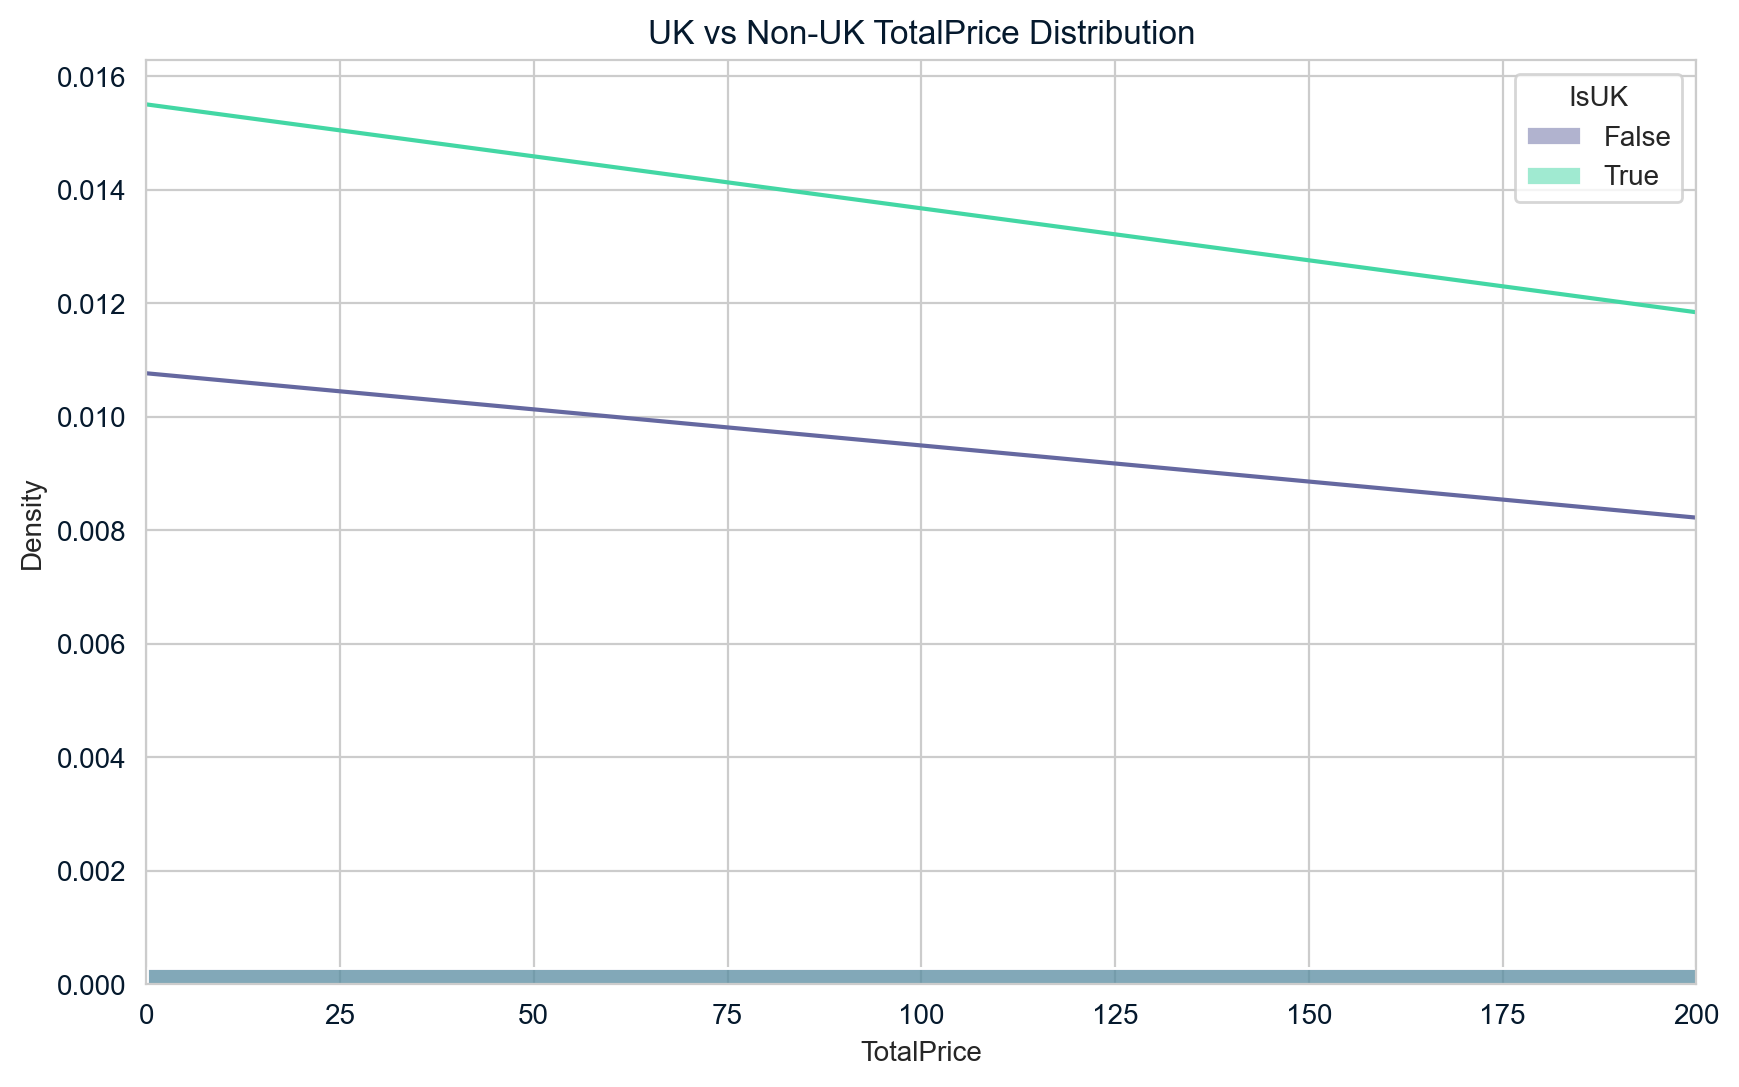

In [34]:
# Visualizing distrubution of data by country groups
plt.figure(figsize=(10,6))
sns.histplot(data=sold, x='TotalPrice', hue='IsUK', kde=True, stat='density', common_norm=False, bins=50, alpha=0.5)
plt.xlim(0,200)
plt.title('UK vs Non-UK TotalPrice Distribution')
plt.show()

The plot above shows that the KDE lines are nearly flat, and the distribution is extremely skewed, likely due to the large scale of the data. To address this, I will apply a log-scale.

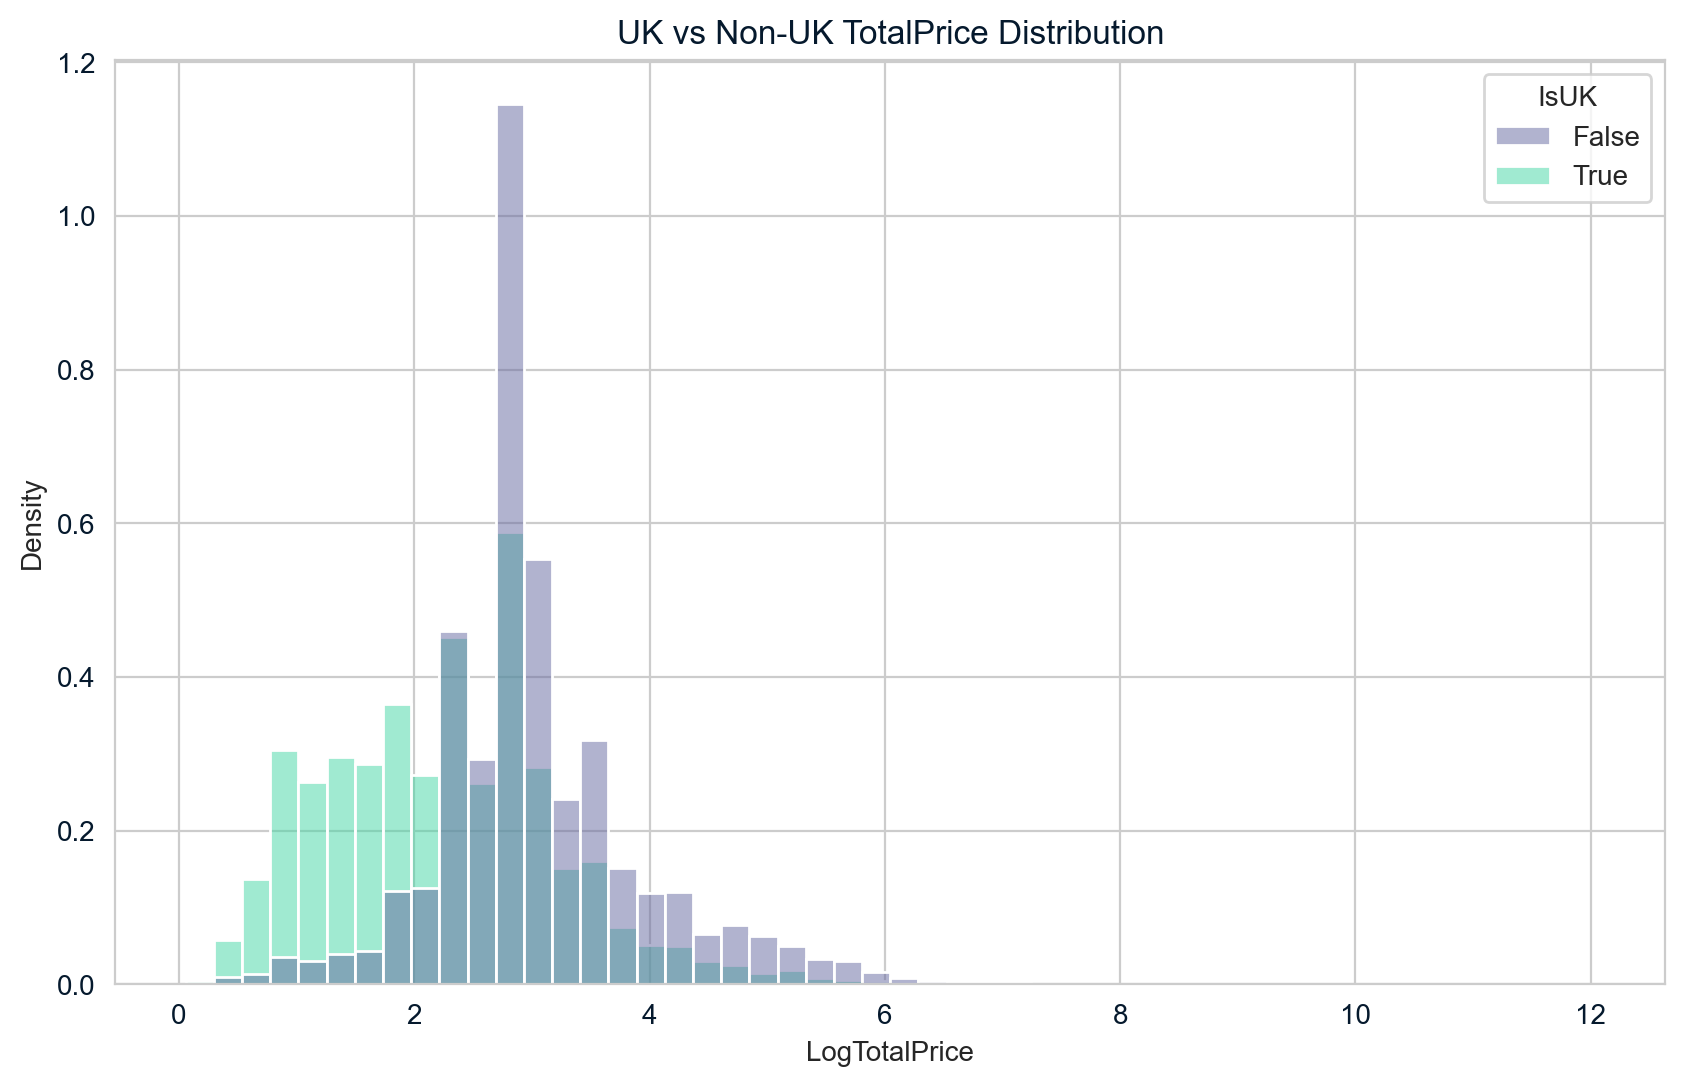

In [35]:
# Visualizing distrubution of the log-scaled data
sold['LogTotalPrice'] = np.log1p(sold['TotalPrice'])
plt.figure(figsize=(10,6))
sns.histplot(data=sold, x='LogTotalPrice', hue='IsUK', stat='density', common_norm=False, bins=50, alpha=0.5)
plt.title('UK vs Non-UK TotalPrice Distribution')
plt.show()

The log-transformed plot reveals the actual shape of the `TotalPrice` distribution. Key observations include:
- UK and Non-UK orders have visibly different centers - UK orders tend to be smaller on average
- Both distributions remain right-skewed, but the skewness is much less extreme (closer to bell-shaped than before)
- There's some overlap between the distributions, but their peaks occur at different values.

Since the data is skewed, has unequal sample sizes, and unequal variances, I will run a Welch's t-test on the log-transform `TotalPrice` data (to correct for the strong skewness in the raw data).

In [36]:
# Performing Welch's t-test
alpha = 0.05
t_stat,  p_value = ttest_ind(
    sold[sold['IsUK']]['LogTotalPrice'],
    sold[~sold['IsUK']]['LogTotalPrice'],
    equal_var=False
)
print('t-statistic: ', t_stat, ', p-value:' , p_value)

t-statistic:  -177.9956001505022 , p-value: 0.0


Let's interpret the results above:
- A very large t-statistic shows that the difference between UK and non-UK orders is massive
- The p-value is so small that Python rounded it down to zero, which means that the difference is statistically significant far beyond any reasonable alpha and we can reject the null hypothesis.

However, to further verify the robustness of these results, I will also perform a Mann-Whitney U test.

In [37]:
# Performing Mann-Whithey U test
non_uk_sales = sold[~sold['IsUK']]['TotalPrice']
uk_sales = sold[sold['IsUK']]['TotalPrice']
mannwhitneyu(non_uk_sales,
            uk_sales,
            alternative='greater')

MannwhitneyuResult(statistic=15515204997.0, pvalue=0.0)

The results lead to the same conclusions - since the u-statistic number is very large, and the p-value is extremely small, we can confidently reject the null hypothesis, indicating that order sizes from countries outside the UK are larger than orders from inside the UK. 

Keeping in mind that the p-value is very small, I will also calculate the effect size to define how big the difference actually is by calculating Cohen's d. 

In [38]:
# Calculating Cohen's d
uk_log = sold[sold['IsUK']]['LogTotalPrice']
non_uk_log = sold[~sold['IsUK']]['LogTotalPrice']
mean_diff = non_uk_log.mean() - uk_log.mean()
pooled_std = np.sqrt((uk_log.var(ddof=1) + non_uk_log.var(ddof=1))/2)
cohens_d = mean_diff / pooled_std
print("Cohen's d: ", cohens_d)

Cohen's d:  0.8431975265580745


The Cohen's d = 0.84 exceeds 0.8 (threshold for a large effect). This means that:
- the difference in average order value between UK and non-UK is substantial
- non-UK orders tend to be much larger than UK orders

In conclusion, statistical tests and effect size calculations show that non-UK customers spend considerably more per order than UK customers, and the difference is practically meaningful.

## 4. Product categories

The fourth task is **to group products into categories**. To better manage inventory, I will group the products into a small number of categories, ensuring the categories are similar in terms of price and quantity sold.

First, I will prepare the data for segmentation by creating a new DataFrame sorted by `StockCode`, including calculated quantity sold and total product revenue.

In [39]:
# Sorting the data by product
sold_by_product = sold.groupby(['StockCode','Description']).agg(
    TotalQty=('Quantity', 'sum'),
    TotalRevenue=('TotalPrice', 'sum')) \
    .reset_index()
sold_by_product.head()

,StockCode,Description,TotalQty,TotalRevenue
0,10002,INFLATABLE POLITICAL GLOBE,860,759.89
1,10080,GROOVY CACTUS INFLATABLE,303,119.09
2,10120,DOGGY RUBBER,193,40.53
3,10123C,HEARTS WRAPPING TAPE,5,3.25
4,10124A,SPOTS ON RED BOOKCOVER TAPE,16,6.72


Second, I will verify that the data is normally distributed and standardized, correcting it if needed.

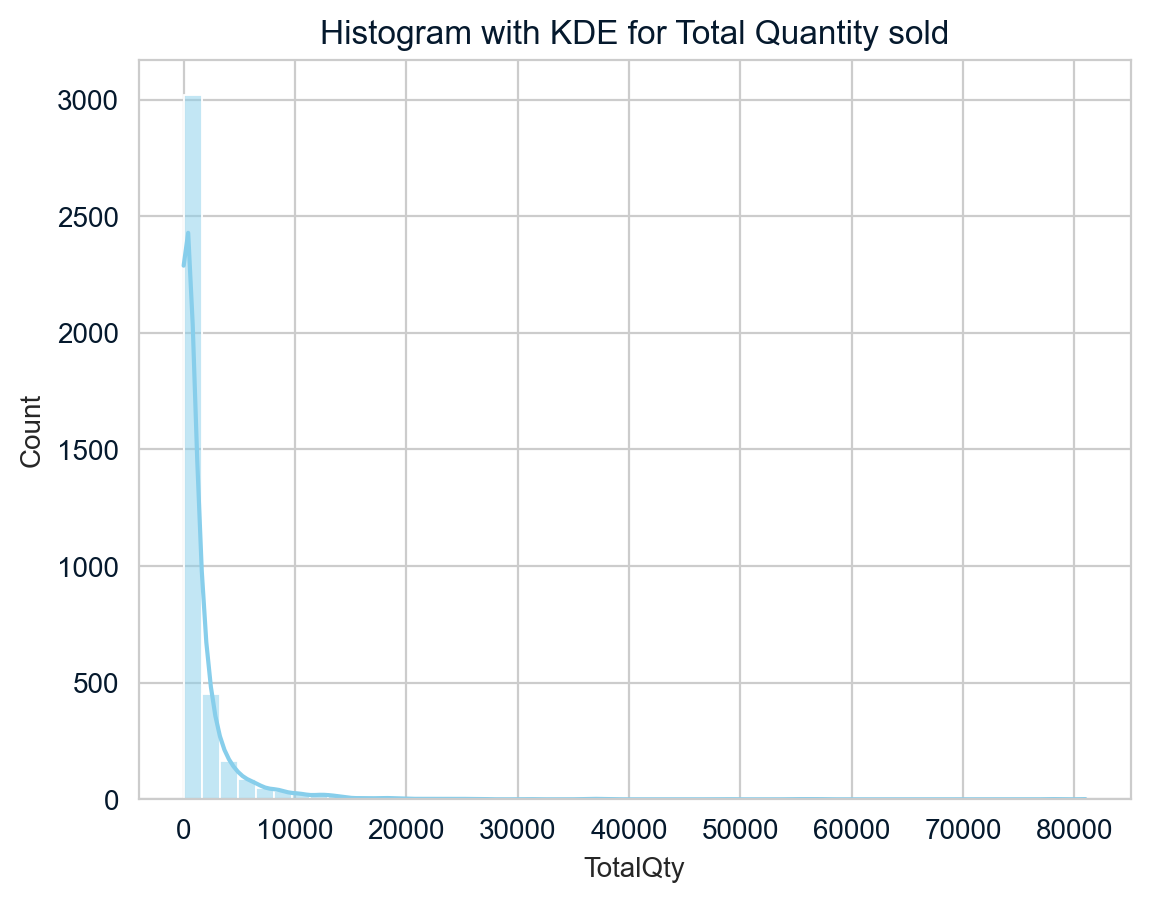

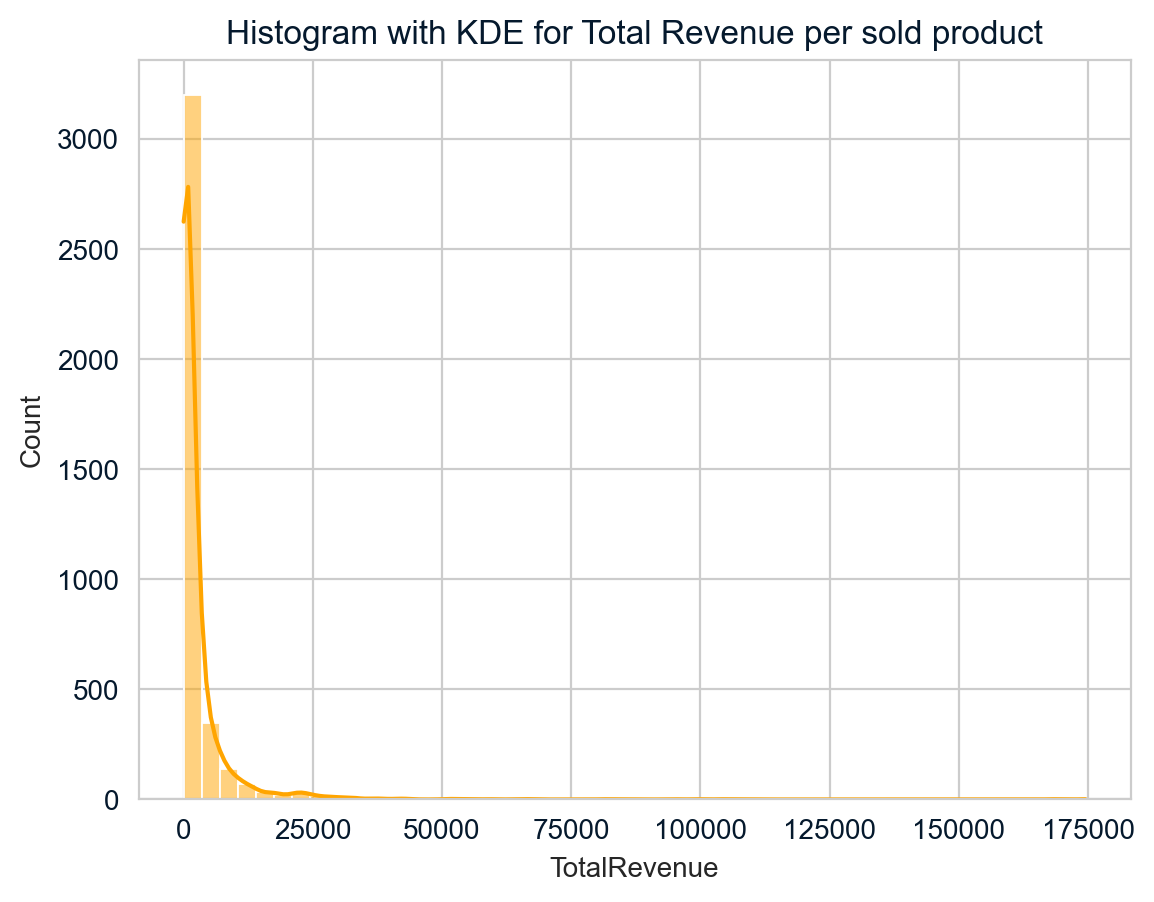

In [40]:
# Checking whether the data is normally distributed
sns.histplot(sold_by_product['TotalQty'], bins=50, kde=True, color='skyblue')
plt.title('Histogram with KDE for Total Quantity sold')
plt.show()

sns.histplot(sold_by_product['TotalRevenue'], bins=50, kde=True, color='orange')
plt.title('Histogram with KDE for Total Revenue per sold product')
plt.show()

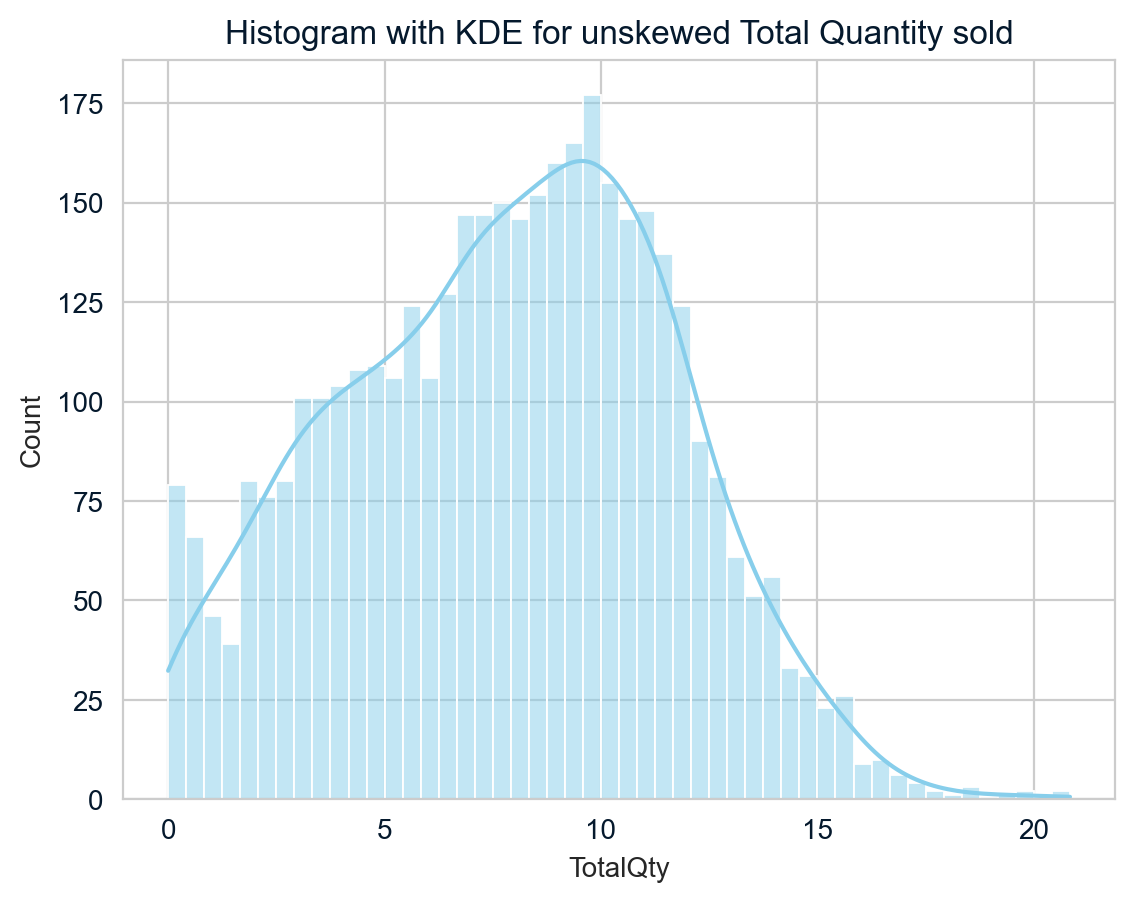

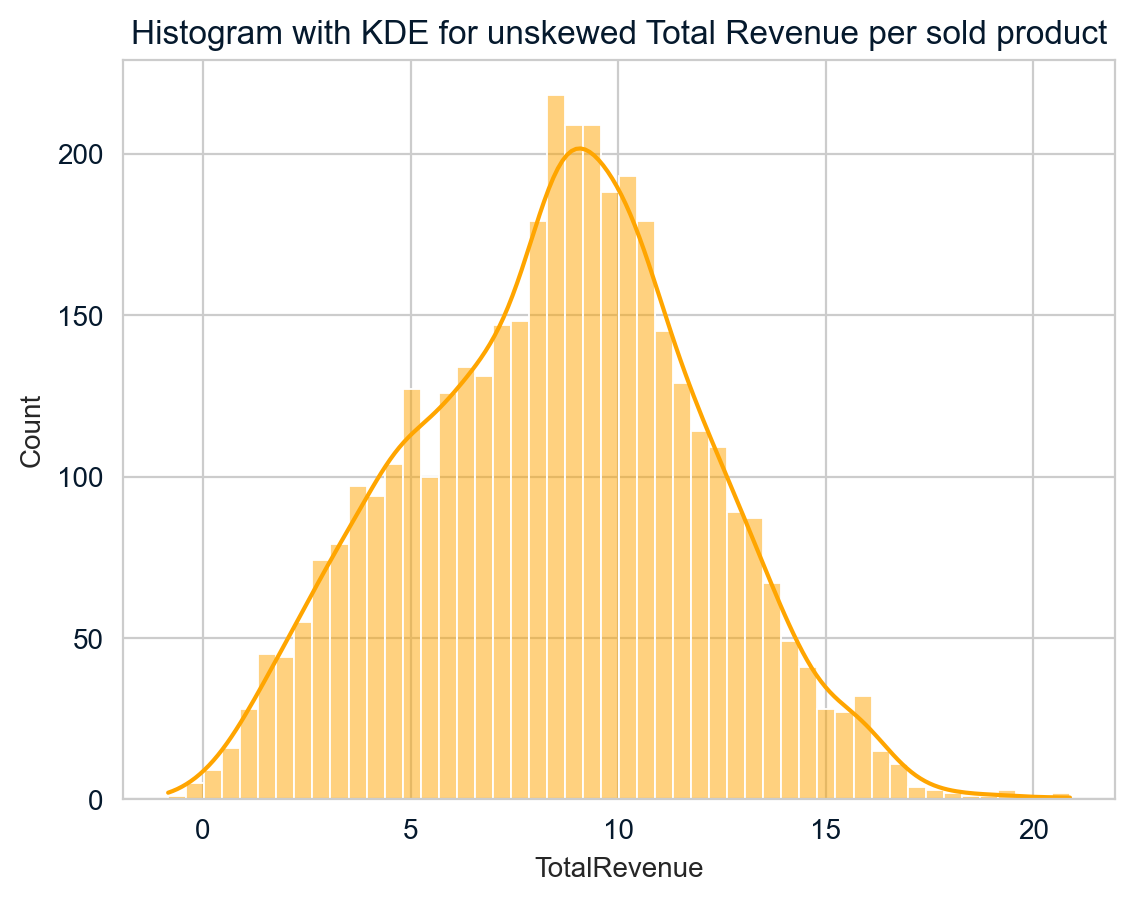

In [41]:
# Unskewing the data with Box-Cox transformation
def boxcox_df(x):
    x_boxcox, _ = stats.boxcox(x)
    return x_boxcox
sold_by_product_boxcox = sold_by_product[['TotalQty','TotalRevenue']].apply(boxcox_df, axis=0)

# Verifying the transformation
sns.histplot(sold_by_product_boxcox['TotalQty'], bins=50, kde=True, color='skyblue')
plt.title('Histogram with KDE for unskewed Total Quantity sold')
plt.show()

sns.histplot(sold_by_product_boxcox['TotalRevenue'], bins=50, kde=True, color='orange')
plt.title('Histogram with KDE for unskewed Total Revenue per sold product')
plt.show()

In [42]:
# Scaling the data
scaler = StandardScaler()
scaler.fit(sold_by_product_boxcox)
sold_by_product_scaled_array = scaler.transform(sold_by_product_boxcox)
sold_by_product_scaled = pd.DataFrame(
    data = sold_by_product_scaled_array,
    index = sold_by_product_boxcox.index,
    columns = sold_by_product_boxcox.columns
)
sold_by_product_scaled.agg(['mean','std']).round()
                                          

,TotalQty,TotalRevenue
mean,0.0,0.0
std,1.0,1.0


With the data unskewed and standardized, I can perform segmentation with K-Means.

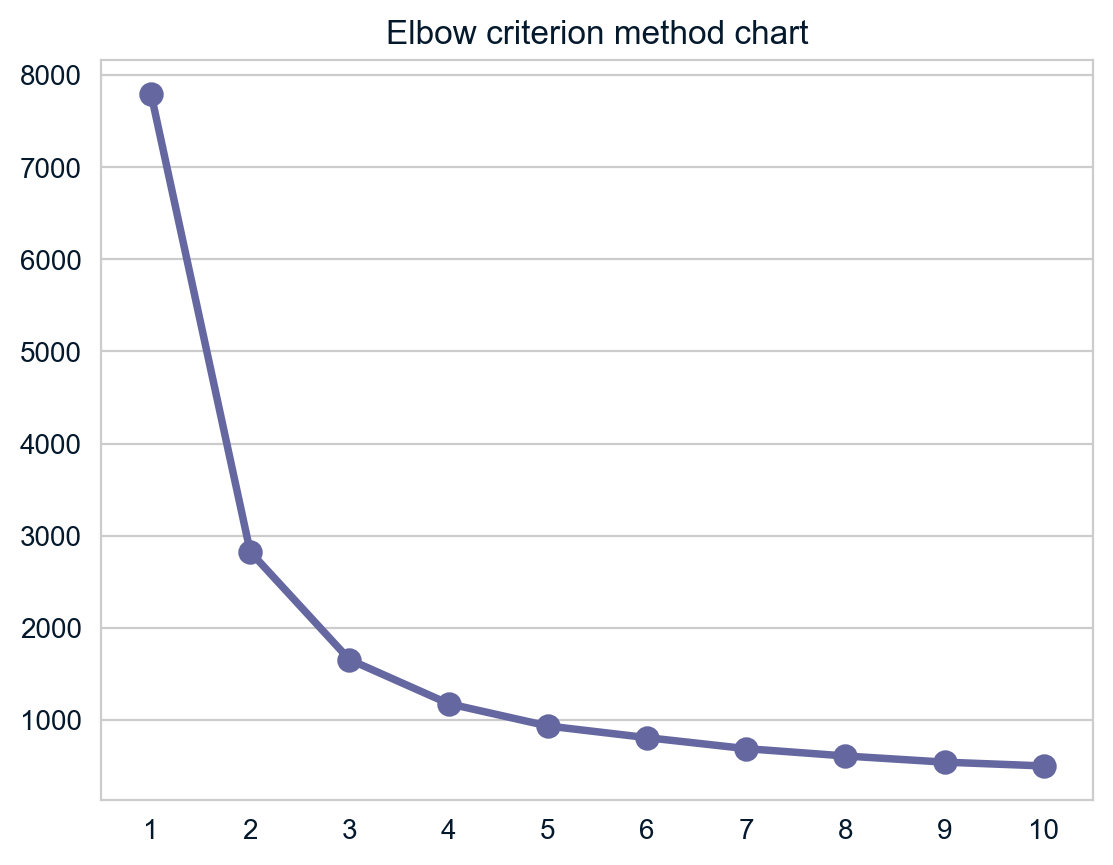

In [43]:
# Identifying the number of clusters
sse = {}
for k in range(1,11):
    kmeans = KMeans(n_clusters=k, random_state=333)
    kmeans.fit(sold_by_product_scaled)
    sse[k] = kmeans.inertia_
plt.title('Elbow criterion method chart')
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

The optimal number of clusters is approximately 3 or 4. \
I will perform K-Means clustering for several values near each optimal k and evaluate the results.

         TotalQty  TotalRevenue
segment                        
0            31.0          69.0
1          4291.0        7990.0
2           558.0         958.0


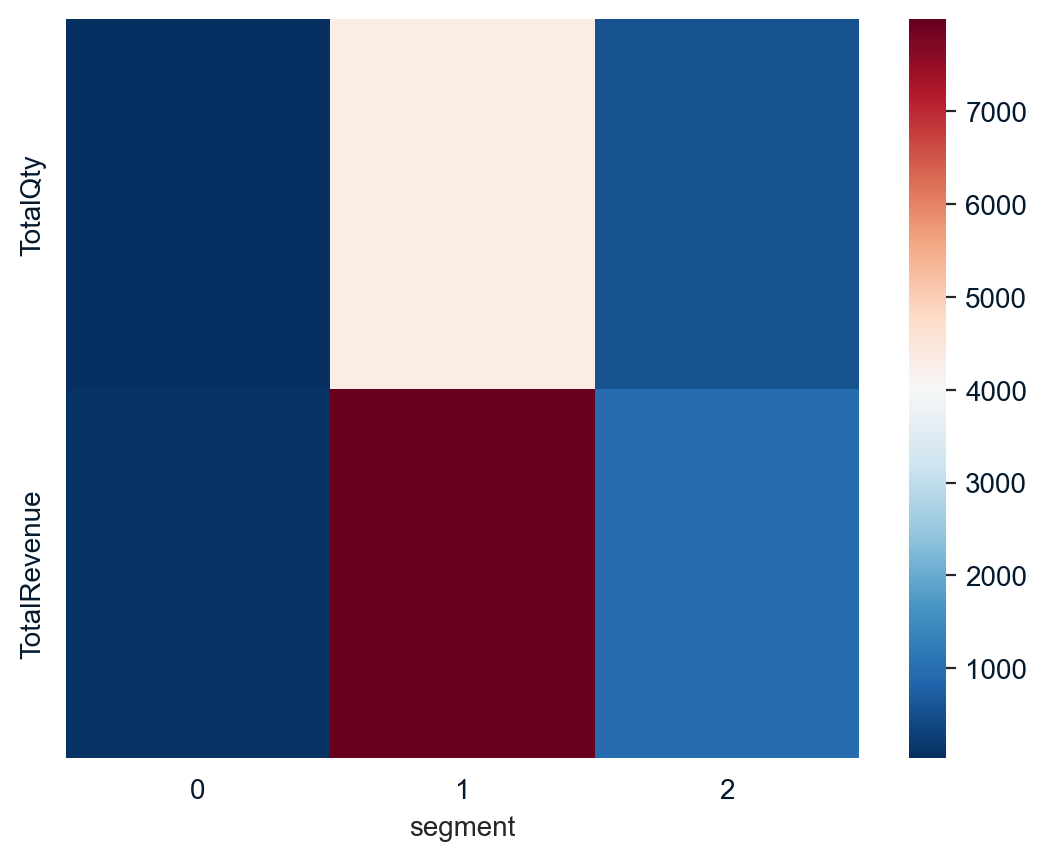

In [44]:
# K-means segmentation with k=3
kmeans = KMeans(n_clusters=3)
kmeans.fit(sold_by_product_scaled)
sold_by_product_kmeans3 = sold_by_product.assign(segment=kmeans.labels_)
kmeans3_averages = sold_by_product_kmeans3.groupby(['segment']).mean(numeric_only=True).round()
print(kmeans3_averages)

# Plotting a heatmap
sns.heatmap(kmeans3_averages.T, cmap='RdBu_r')
plt.show()

The enterpretation:
- the first segment represents very low sellers, the products may be called "niche" or "deadstock"
- the second segment represents high sellers, the products are likely "bestsellers" that move in large volumes and generate big revenue
- the third segment represents mid-level products: neither top sellers nor deadstock.

         TotalQty  TotalRevenue
segment                        
0            14.0          33.0
1          5763.0       11099.0
2           152.0         333.0
3          1060.0        1673.0


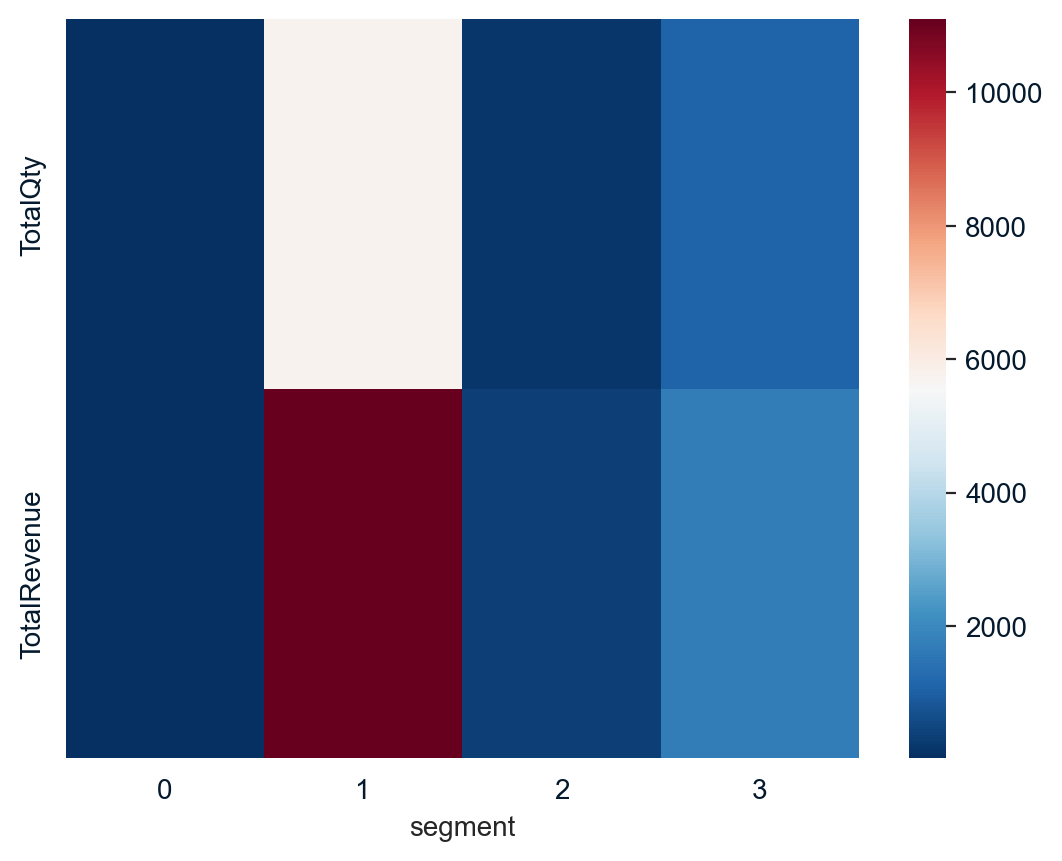

In [47]:
# K-means segmentation with k=4
kmeans = KMeans(n_clusters=4)
kmeans.fit(sold_by_product_scaled)
sold_by_product_kmeans4 = sold_by_product.assign(segment=kmeans.labels_)
kmeans4_averages = sold_by_product_kmeans4.groupby(['segment']).mean(numeric_only=True).round()
print(kmeans4_averages)

# Plotting a heatmap
sns.heatmap(kmeans4_averages.T, cmap='RdBu_r')
plt.show()

The enterpretation:
- the first segment represents "deadstock", there's almost no movement
- the second segment represents super-high sellers (even stronger "bestsellers")
- the third segment represents small sellers (but still moving compared to deadstock)
- the fourth segment represents strong sellers (but not as extreme as segment 2).

From the segmentations above, k=3 provides a simple overview if the business required a high-level summary. \
For actionable segmentation, k=4 is preferable, as it distinguishes solid sellers from blockbusters and separates low from deadstock. \n
Assuming the business requires more detailed segmentation, I chose k=4. This produces four product groups with clear differences in sales and revenue. The results show which products bring the most value and which have lower impact. This helps the business focus on marketing, stock, and strategy for each group.